# Random sampling from CSV

In [13]:
import pandas as pd

# Load the original CSV file
original_df = pd.read_csv("/teamspace/studios/this_studio/Deeplab/pilot_small_eastafrica_haiti_freetown_WITH_deeplab_crf_sam.csv")

# Choose 250 random rows from the original dataframe
random_rows = original_df.sample(n=50)

# Save the selected random rows to a new CSV file
random_rows.to_csv("giggles.csv", index=False)


# Poly remove with heirarchy

In [17]:
import cv2
import numpy as np

def polygon_vertices(mask):
    '''
    Find contours in the binary image and return both external and internal polygons.

    mask: binary image to find contours in
    '''
    # Convert the image into 0 and 1 (background and foreground)
    _, binary_image = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Find contours and hierarchy
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Extract segmentations
    external_polygons = []
    internal_polygons = []
    if hierarchy is not None:
        hierarchy = hierarchy[0]  # Flatten the hierarchy array
        for i, contour in enumerate(contours):
            # Approximate contour to polygon
            if len(contour) < 3:
                continue

            contour = cv2.approxPolyDP(contour, 1, True)
            segmentation = contour.flatten().tolist()

            # Determine if the contour is external or internal
            if hierarchy[i][3] == -1:
                # External contour
                external_polygons.append(segmentation)
            else:
                # Internal contour
                internal_polygons.append(segmentation)

    return external_polygons, internal_polygons




def calculate_polygon_area(vertices):
    # Ensure the polygon is closed (first and last vertices are the same)
    if vertices[0] != vertices[-2] or vertices[1] != vertices[-1]:
        vertices.extend(vertices[:2])

    # Calculate the area using the shoelace formula
    area = 0
    n = len(vertices) // 2
    for i in range(n - 1):
        area += (vertices[2*i] * vertices[2*i+3] - vertices[2*i+1] * vertices[2*i+2])
    area += (vertices[2*n-2] * vertices[1] - vertices[2*n-1] * vertices[0])
    return abs(area) / 2

def create_pair(t):
  pair = list(zip(t[::2],t[1::2]))
  new_pair = []
  for i in pair:
    new_pair.append(list(i))
  return new_pair

def remove_small_polygons(mask, threshold):
    if not isinstance(mask,np.ndarray):
        print('Takes a numpy array as input with entries either 0 or 255.')
        return
    segmentation, inner_polygons = polygon_vertices(mask)[0], polygon_vertices(mask)[1]
      
    outer_polygons = [polygon for polygon in segmentation if calculate_polygon_area(polygon) > threshold]
    
    binary_mask = np.zeros(mask.shape, dtype=np.uint8)
    for i in outer_polygons:
      pair = create_pair(i)
      polygon_points = np.array(pair, np.int32)
      cv2.fillPoly(binary_mask, [polygon_points], 255)
    
    for i in inner_polygons:
        pair = create_pair(i)
        polygon_points = np.array(pair, np.int32)
        cv2.fillPoly(binary_mask, [polygon_points], 0)

    
    return binary_mask/255



In [10]:
# Deeplab/india_sam_dino_annotations/binary_masks/india_psidguaj (guava)2020.10.31.16.25.24_25.3053188463673_79.31931177154183_c13a564b-c93c-49ed-9415-492a3ca3b7c7_img_20201031_112008_1335220262188352886_binarymask.jpg
mask = cv2.imread('/teamspace/studios/this_studio/Deeplab/india_sam_dino_annotations/binary_masks/india_psidguaj (guava)2020.10.31.16.25.24_25.3053188463673_79.31931177154183_c13a564b-c93c-49ed-9415-492a3ca3b7c7_img_20201031_112008_1335220262188352886_binarymask.jpg',cv2.IMREAD_GRAYSCALE)

In [11]:
print(type(mask))

<class 'numpy.ndarray'>


In [12]:
print(mask.shape)

(512, 512)


[[150, 307, 153, 303, 161, 306, 176, 306, 178, 308, 179, 313, 172, 314, 156, 309, 151, 309], [267, 263, 289, 266, 297, 270, 298, 282, 306, 306, 305, 310, 302, 309, 296, 303, 290, 292, 282, 286, 277, 277, 266, 265], [257, 263, 256, 274, 258, 282, 255, 284, 208, 277, 189, 269, 189, 289, 172, 292, 151, 288, 149, 286, 149, 280, 151, 278, 174, 276, 181, 268, 188, 267, 200, 261, 224, 257, 225, 266, 227, 270, 229, 270, 232, 266, 247, 260, 254, 260]]


In [19]:
returned_array = (remove_small_polygons(mask,100))*225

In [20]:
cv2.imwrite('poly_with_heirarchy.jpg', returned_array)

True

In [21]:
import boto3

s3 = boto3.resource()

In [51]:
my_bucket = s3.Bucket('treetracker-training-images')
sample_objects = my_bucket.objects.filter(Prefix='pilot_with_crf/samples/')
mask_objects = my_bucket.objects.filter(Prefix='pilot_with_crf/binary_masks/')


sample_paths = []
mask_paths = []

for obj in sample_objects:
  sample_paths.append(obj.key)

for obj in mask_objects:
  mask_paths.append(obj.key)

print("masks - " + str(len(mask_paths)))
print("samples - " + str(len(sample_paths)))

masks - 250
samples - 250


In [52]:
def convert_path(input_path):
    # Split the input path into parts
    parts = input_path.split('/')
    
    # Modify the parts as required
    parts[1] = 'binary_masks'
    file_name = parts[-1]
    
    # Split the file name and add '_binarymask' before the extension
    name_parts = file_name.rsplit('.', 1)
    name_parts[0] += '_binarymask'
    
    # Combine the modified file name
    new_file_name = '.'.join(name_parts)
    parts[-1] = new_file_name
    
    # Join the parts back into a full path
    new_path = '/'.join(parts)
    
    return new_path

In [23]:
print(mask_paths[1])

pilot_with_crf_large/binary_masks/eastafrica_acactort_2020.06.02.20.08.58_34e14725-f120-4c13-8e7a-22504760999b_img_20100103_110943_1636935822_binarymask.jpg


In [25]:
show(mask_paths[1], my_bucket = my_bucket)

Local path not valid.


In [26]:
print(is_s3_object_key(mask_paths[0]))

False


In [27]:
def show_mask(to_read, my_bucket=None, size=(10, 10)):
    s3_object = my_bucket.Object(to_read).get()
    image = flip(Image.open(io.BytesIO(s3_object['Body'].read())))
    
    plt.figure(figsize=size)
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    plt.close()

In [ ]:
for i in range(10):
    r = random.randint(1,len(sample_paths))
    show_mask(sample_paths[r], my_bucket=my_bucket)
    show_mask(convert_path(sample_paths[r]), my_bucket = my_bucket)

In [72]:
from PIL import Image
import io
import matplotlib.pyplot as plt
import numpy as np

def clean_small_poly(s3_key):
    # Fetch the object from S3
    s3_object = my_bucket.Object(s3_key).get()
    image = flip(Image.open(io.BytesIO(s3_object['Body'].read())))
    
    # Convert image to grayscale
    image_gray = image.convert('L')
    
    # Convert to numpy array
    image_array_gray = np.array(image_gray)
    
    # Threshold the grayscale image to create a binary image
    threshold_value = 127  
    binary_image_array = np.where(image_array_gray > threshold_value, 255, 0).astype(np.uint8)
    
    # Remove small polygons
    cleaned_mask = remove_small_polygons(binary_image_array, 100)
    
    # Convert cleaned mask to binary (0 and 255)
    cleaned_mask = (cleaned_mask * 255).astype(np.uint8)
    
    # Convert the cleaned mask back to a PIL image
    cleaned_image = Image.fromarray(cleaned_mask, 'L')
    
    # Display the cleaned image
    plt.figure(figsize=(10, 10))
    plt.imshow(cleaned_image, cmap='gray')
    plt.axis("off")
    plt.show()
    plt.close()


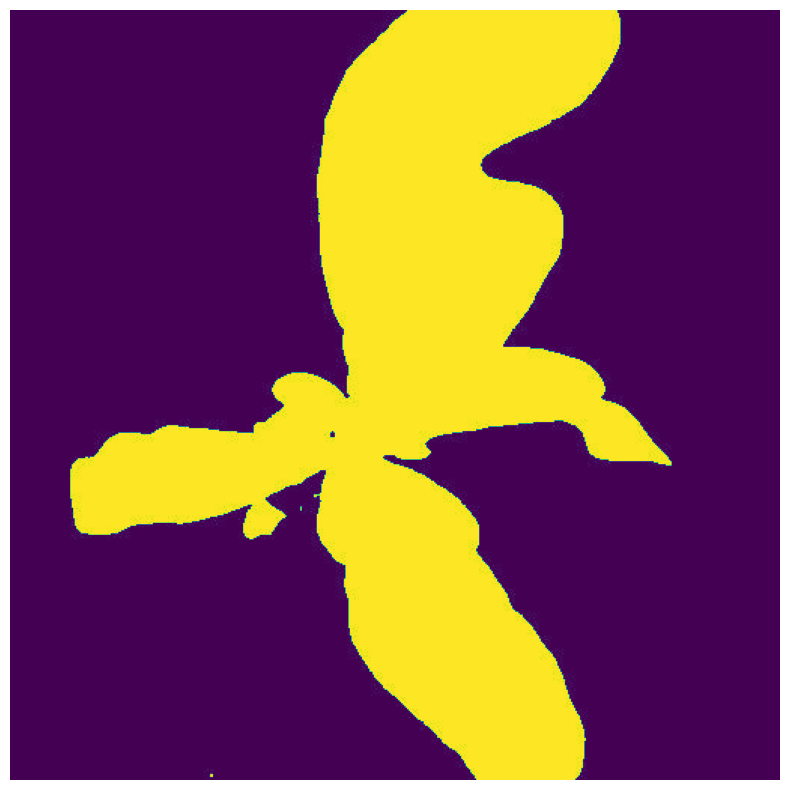

In [70]:
show_mask(mask_paths[223],my_bucket=my_bucket)

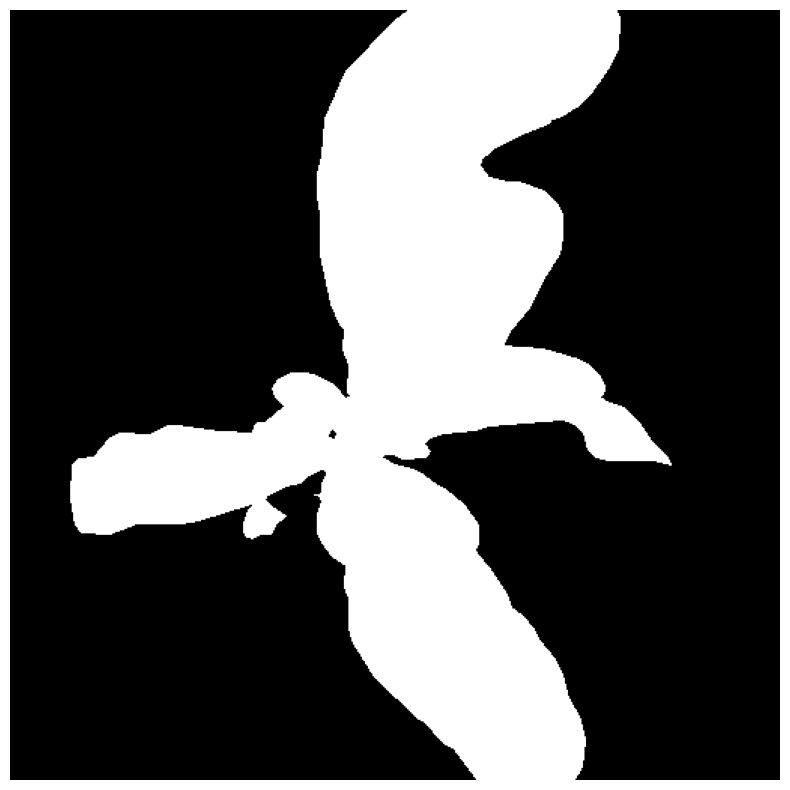

In [73]:
clean_small_poly(mask_paths[223])

In [ ]:
for i in range(10):
    r = random.randint(1,len(sample_paths))
    show_mask(mask_paths[r],my_bucket=my_bucket)
    clean_small_poly(mask_paths[r])

In [76]:
import shutil

def remove_folder_contents(folder_path):
    try:
        shutil.rmtree(folder_path)
        print(f"All contents of {folder_path} have been removed successfully.")
    except Exception as e:
        print(f"An error occurred while removing contents of {folder_path}: {e}")

# Example usage:
folder_path = "/teamspace/studios/this_studio/Deeplab/crf_sam_annotations_large/samples"
remove_folder_contents(folder_path)


All contents of /teamspace/studios/this_studio/Deeplab/crf_sam_annotations_large/samples have been removed successfully.
